# Curve smoothing exercise

In [2]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# Read data
in_dir = '../../../data/week1/curves/'
X = np.loadtxt(in_dir + 'hand_noisy.txt')

### Task 1
Explicit (forward) smooting.

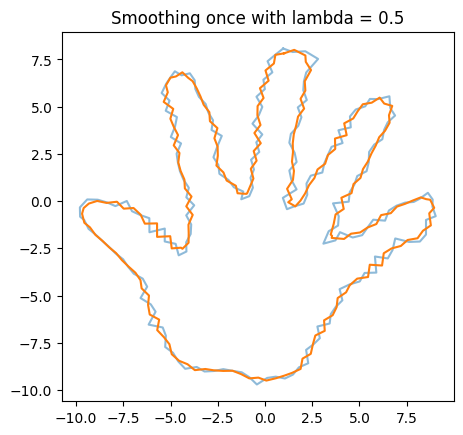

In [3]:
# Make circulant smoothing matrix
l = np.zeros(X.shape[0])
l[[-1, 0, 1]] = [1, -2, 1]
L = scipy.linalg.circulant(l)

# Smoothing parameter
lmb = 0.5

# Smooth the curve
X1 = (np.eye(X.shape[0]) + lmb * L) @ X

# Plot the results - use indexing to plot closed curve
idx = np.arange(X.shape[0] + 1)
idx[-1] = 0
fig, ax = plt.subplots()
ax.plot(X[idx, 0], X[idx, 1], alpha=0.5)
ax.plot(X1[idx, 0], X1[idx, 1])
ax.set_aspect('equal')
ax.set_title(f'Smoothing once with lambda = {lmb}')
plt.show()

Explicit smoothing works only for small $\lambda$ (try for example a value 1.5 in the cell above).  To achieve more aggressive smoothing, we need to smooth iteratively.  This requires setting two parameters: $\lambda$ and the number of iterations.

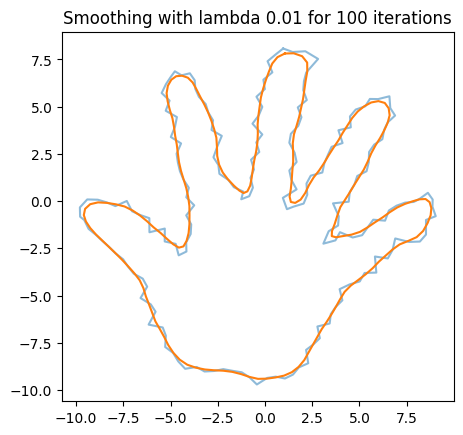

In [4]:
# Smoothing parameters
n_iter = 100
lmb = 0.01  

# Smooth the curve
Xn = X.copy()
for i in range(n_iter):
    Xn = (np.eye(X.shape[0]) + lmb * L) @ Xn

# Show the results
fig, ax = plt.subplots()
ax.plot(X[idx, 0], X[idx, 1], alpha=0.5) 
ax.plot(Xn[idx, 0], Xn[idx, 1])
ax.set_aspect('equal')
ax.set_title(f'Smoothing with lambda {lmb} for {n_iter} iterations')
plt.show()


Let's visualize every iteration using `ipwidgets`.

In [5]:
from ipywidgets import interact

n_iter = 100
lmb = 0.5  

X_iters = [X]
for i in range(n_iter):
    X_iters.append((np.eye(X.shape[0]) + lmb * L) @ X_iters[-1])

def show_iter(i):
    plt.plot(X[idx, 0], X[idx, 1], alpha=0.5) 
    plt.plot(X_iters[i][idx, 0], X_iters[i][idx, 1])
    plt.title(f'Smoothing with lambda {lmb} iter {i}')
    plt.gca().set_aspect('equal')
    plt.show()

interact(show_iter, i=(0, n_iter, 1));

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

### Task 2 Implicit smoothing
With implicit smoothing, we can use a large smoothing parameter.

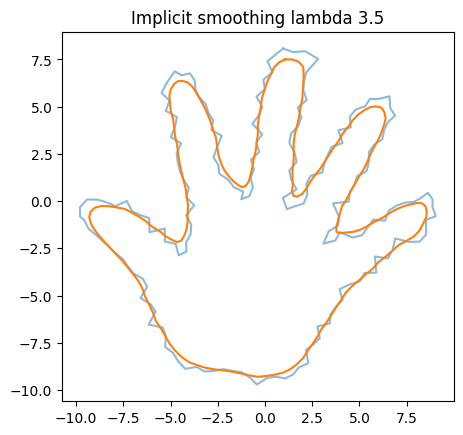

In [6]:
# Smoothing parameter and smoothing
lmb = 3.5 
X_implicit = np.linalg.inv(np.eye(X.shape[0]) - lmb * L) @ X

# Show the results
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(X[idx,0], X[idx,1], alpha=0.5)
ax.plot(X_implicit[idx,0], X_implicit[idx,1])
ax.set_title(f'Implicit smoothing lambda {lmb}')
plt.show()

### Task 3 Extended kernel

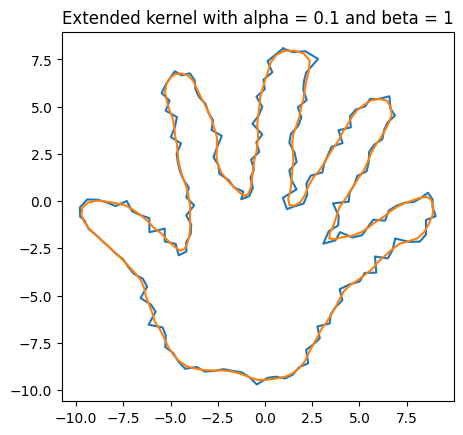

In [7]:
# Circulant smoothing matrices
a = np.zeros(X.shape[0]) # Array for first order derivative
a[[-1, 0, 1]] = [1, -2, 1]
A = scipy.linalg.circulant(a) # Circulant matrix for first order derivative
b = np.zeros(X.shape[0]) # Array for second order derivative
b[[-2, -1, 0, 1, 2]] = [-1, 4, -6, 4, -1]
B = scipy.linalg.circulant(b) # Circulant matrix for second order derivative

# Smoothing parameters
alpha = 0.1
beta = 1

# Smooth the curve
Xn = X.copy()
Xn = np.linalg.inv(np.eye(X.shape[0]) - alpha*A - beta*B)@Xn

# Show the results
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(X[idx,0], X[idx,1])
ax.plot(Xn[idx,0], Xn[idx,1])
ax.set_title(f'Extended kernel with alpha = {alpha} and beta = {beta}')
plt.show()

### Task 4 Making a function for smoothing matrix

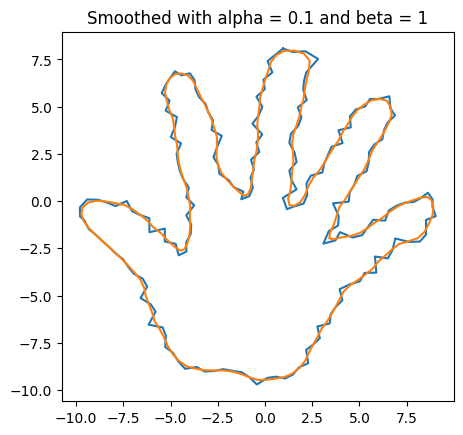

In [8]:
def regularization_matrix(N, alpha, beta):
    '''Returns circulant N x N matrix for imposing elasticity and rigidity to snakes.
     
    Parameters
    ----------
    N : int
        Number of points in the curve.

    alpha : float
        Weight for elasticity.

    beta : float
        Weight for rigidity.

    Returns
    -------
    ndarray
        Circulant N x N smoothing matrix.
    
    '''
    s = np.zeros(N)
    s[[-2, -1, 0, 1, 2]] = (alpha * np.array([0, 1, -2, 1, 0]) + 
                    beta * np.array([-1, 4, -6, 4, -1]))
    S = scipy.linalg.circulant(s)  
    return scipy.linalg.inv(np.eye(N) - S)

# Smoothing parameters and smoothing
alpha = 0.1
beta = 1
X_smoothed = regularization_matrix(X.shape[0], alpha, beta) @ X

# Show the results
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(X[idx, 0], X[idx, 1])
ax.plot(X_smoothed[idx, 0], X_smoothed[idx, 1])
ax.set_title(f'Smoothed with alpha = {alpha} and beta = {beta}')
plt.show()

### Extra: interactive display

In [9]:
from ipywidgets import interact

X_smoothed = {}
for a in np.round(np.arange(0, 10.1, 0.25), 2): #  round to avoid floating point errors
    for b in np.round(np.arange(0, 10.1, 0.25), 2):
        X_smoothed[a, b] = regularization_matrix(X.shape[0], a, b) @ X

def show_result(a, b):
    plt.plot(X[idx, 0], X[idx, 1], alpha=0.5) 
    plt.plot(X_smoothed[a, b][idx, 0], X_smoothed[a, b][idx, 1])
    plt.title(f'Smoothing with alpha {a} beta {b}')
    plt.gca().set_aspect('equal')
    plt.show()

interact(show_result, a=(0, 10, 0.25), b=(0, 10, 0.25));

interactive(children=(FloatSlider(value=5.0, description='a', max=10.0, step=0.25), FloatSlider(value=5.0, des…